In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from functools import partial
import visualizations_utils as viz_utils
from iris_plant_visualizer import IrisPlantVisualizer
import ipywidgets as widgets
from IPython.display import display

In [3]:
#pydrake imports
import pydrake
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.geometry import Role, GeometrySet, CollisionFilterDeclaration
from pydrake.solvers import mathematicalprogram as mp
from pydrake.all import RigidTransform, RollPitchYaw, RevoluteJoint

import pydrake.multibody.rational_forward_kinematics as rational_forward_kinematics
from pydrake.all import RationalForwardKinematics
from pydrake.geometry.optimization import (IrisOptionsRationalSpace, 
                                           IrisInRationalConfigurationSpace, 
                                           HPolyhedron, 
                                           Hyperellipsoid,
                                           Iris, IrisOptions)
from visprm import VPRMSeeding
from dijkstraspp import DijkstraSPPsolver                                          

# Build and set up the visualization the plant and the visualization of the C-space obstacle

Note that running this cell multiple times will establish multiple meshcat instances which can fill up your memory. It is a good idea to call "pkill -f meshcat" from the command line before re-running this cell

In [4]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
parser = Parser(plant)
oneDOF_iiwa_asset = FindResourceOrThrow("drake/C_Iris_Examples/assets/oneDOF_iiwa7_with_box_collision.sdf")
twoDOF_iiwa_asset = FindResourceOrThrow("drake/C_Iris_Examples/assets/twoDOF_iiwa7_with_box_collision.sdf")

box_asset = FindResourceOrThrow("drake/C_Iris_Examples/assets/box_small.urdf")

models = []
models.append(parser.AddModelFromFile(box_asset))
models.append(parser.AddModelFromFile(twoDOF_iiwa_asset))
models.append(parser.AddModelFromFile(oneDOF_iiwa_asset))



locs = [[0.,0.,0.],
        [0.,.55,0.],
        [0.,-.55,0.]]
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("base", models[0]),
                 RigidTransform(locs[0]))
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("iiwa_twoDOF_link_0", models[1]), 
                 RigidTransform(RollPitchYaw([0,0, -np.pi/2]).ToRotationMatrix(), locs[1]))
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("iiwa_oneDOF_link_0", models[2]), 
                 RigidTransform(RollPitchYaw([0,0, -np.pi/2]).ToRotationMatrix(), locs[2]))


plant.Finalize()

idx = 0
q0 = [0.0, 0.0, 0.0]
q_low  = [-1.7, -2., -1.7]
q_high = [ 1.7,  2.,  1.7]
# set the joint limits of the plant
for model in models:
    for joint_index in plant.GetJointIndices(model):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[idx])
            joint.set_position_limits(lower_limits= np.array([q_low[idx]]), upper_limits= np.array([q_high[idx]]))
            idx += 1
        
# construct the RationalForwardKinematics of this plant. This object handles the
# computations for the forward kinematics in the tangent-configuration space
Ratfk = RationalForwardKinematics(plant)

# the point about which we will take the stereographic projections
q_star = np.zeros(3)

#compute limits in t-space
limits_t = []
for q in [q_low, q_high]:
    limits_t.append(Ratfk.ComputeTValue(np.array(q), q_star))

do_viz = True

# This line builds the visualization. Change the viz_role to Role.kIllustration if you
# want to see the plant with its illustrated geometry or to Role.kProximity
visualizer = IrisPlantVisualizer(plant, builder, scene_graph, viz_role=Role.kIllustration)
diagram = visualizer.diagram

# This line will run marching cubes to generate a mesh of the C-space obstacle
# Increase N to increase the resolution of the C-space obstacle.
visualizer.visualize_collision_constraint(N = 60)

INFO:drake:Meshcat listening for connections at http://localhost:7004
INFO:drake:Meshcat listening for connections at http://localhost:7005
/home/peter/git/vprmintegration/drake/C_Iris_Examples/iris_plant_visualizer.py:31: DrakeDeprecationWarning: MeshcatVisualizerCpp has been renamed to MeshcatVisualizer. The deprecated code will be removed from Drake on or after 2022-11-01.
  self.vis = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, self.meshcat1)


# Set up the sliders so we can move the plant around manually


In [5]:
sliders = []
sliders.append(widgets.FloatSlider(min=q_low[0], max=q_high[0], value=0, description='q0'))
sliders.append(widgets.FloatSlider(min=q_low[1], max=q_high[1], value=0, description='q1'))
sliders.append(widgets.FloatSlider(min=q_low[2], max=q_high[2], value=0, description='q2'))

q = q0.copy()
def handle_slider_change(change, idx):
    q[idx] = change['new']
    visualizer.showres(q)
    visualizer.visualize_planes()
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=1.7, min=-1.7)

FloatSlider(value=0.0, description='q1', max=2.0, min=-2.0)

FloatSlider(value=0.0, description='q2', max=1.7, min=-1.7)

In [6]:
# filter fused joints self collisions so they don't interfere with collision engine
digaram = visualizer.diagram
context = visualizer.diagram_context
sg_context = scene_graph.GetMyContextFromRoot(context)
inspector = scene_graph.model_inspector()

pairs = scene_graph.get_query_output_port().Eval(sg_context).inspector().GetCollisionCandidates()

gids = [gid for gid in inspector.GetGeometryIds(GeometrySet(inspector.GetAllGeometryIds()), Role.kProximity)]
get_name_of_gid = lambda gid : inspector.GetName(gid)
gids.sort(key=get_name_of_gid)
iiwa_oneDOF_gids = [gid for gid in gids if "iiwa7_oneDOF::" in get_name_of_gid(gid)]
iiwa_twoDOF_gids = [gid for gid in gids if "iiwa7_twoDOF::" in get_name_of_gid(gid)]

oneDOF_fused_col_geom = iiwa_oneDOF_gids[2:]
iiwa_oneDOF_fused_set = GeometrySet(oneDOF_fused_col_geom)
twoDOF_fused_col_geom = iiwa_twoDOF_gids[4:]
iiwa_twoDOF_fused_set = GeometrySet(twoDOF_fused_col_geom)
scene_graph.collision_filter_manager()\
            .Apply(CollisionFilterDeclaration().ExcludeWithin(iiwa_oneDOF_fused_set))
scene_graph.collision_filter_manager()\
            .Apply(CollisionFilterDeclaration().ExcludeWithin(iiwa_twoDOF_fused_set))

In [7]:
# Some examples of some seed points which give large regions using the
# non-linear programming approach to IRIS described in Algorithm 3
seed1 = np.array([ 1.6, -0.4, -1.3])
seed2 = np.array([ 0.9, -0.9, -1.7])
poi = np.array([seed1, seed2])
poi_t = np.array([Ratfk.ComputeTValue(poi[idx], np.zeros((3,)))\
                        for idx in range(poi.shape[0])])
if do_viz:
    visualizer.plot_seedpoints(poi_t)

# Setup SNOPT IRIS

In [8]:
domain = HPolyhedron.MakeBox( Ratfk.ComputeTValue(q_low, np.zeros((3,))), Ratfk.ComputeTValue(q_high, np.zeros((3,))))
snopt_iris_options = IrisOptionsRationalSpace()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 20
snopt_iris_options.configuration_space_margin = 1e-5
snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.relative_termination_threshold = 0.05


def SNOPT_IRIS(q_seed,  regions, plant, context, snoptiris_options, default_domain):
    #print('snopt iris call')
    snoptiris_options.configuration_obstacles = []
    if regions is not None:
        obstacles = []
        for r in regions:
            offset = 0.25*np.min(1/np.linalg.eig(r.MaximumVolumeInscribedEllipsoid().A())[0])
            rnew = HPolyhedron(r.A(), r.b()-offset)
            obstacles.append(rnew)
        snopt_iris_options.configuration_obstacles = obstacles
    plant.SetPositions(plant.GetMyMutableContextFromRoot(context), q_seed.reshape(-1,1))
    r = IrisInRationalConfigurationSpace(plant, plant.GetMyContextFromRoot(context), snoptiris_options, domain)
    return r

SNOPT_IRIS_Handle = partial(SNOPT_IRIS,
                            plant = plant,
                            context = context,
                            snoptiris_options = snopt_iris_options,
                            default_domain = domain)

# Construct vis checker (here still sample based)

In [9]:
def vis(t1, t2, num_checks, visualizer):
    t1flat = t1.reshape(-1)
    t2flat = t2.reshape(-1)
    if np.linalg.norm(t1-t2) < 1e-6:
        return [(1-visualizer.col_func_handle(Ratfk.ComputeQValue(t1flat, np.zeros(3))))>0,
                None]
    tvec = np.linspace(0,1, num_checks)
    for t in tvec:
        tinterp = t1flat*t + (1-t)*t2flat
        if visualizer.col_func_handle(Ratfk.ComputeQValue(tinterp, np.zeros(3))):
            return [False, None]
    else:
        return [True, None]
is_LOS = partial(vis, num_checks = 40, visualizer = visualizer)

# Run Seeding Setup and Guard Phase


In [10]:
visualizer.meshcat2.Delete('/iris')
np.random.seed(10)
vs = VPRMSeeding(poi,
                 alpha = 0.1,
                 limits = [np.array(q_low), np.array(q_high)],
                 collision_handle = visualizer.col_func_handle,
                 is_in_line_of_sight = is_LOS, 
                 iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
                 iris_handle_with_obstacles = SNOPT_IRIS_Handle,
                 point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(3))
                 )

vs.set_guard_regions()

[14:38:12] [VPRMSeeding] Expecting points of interest in q
[14:38:12] [VPRMSeeding] GuardInsertion attempts M: 44
[14:38:12] [VPRMSeeding] 0.9 probability that unseen region is less than 5.0 "%" of Cfree 


In [11]:
vs.guard_phase()
vs.guard_phase()

[14:38:13] [VPRMSeeding] New guard placed N =  2 it =  0
[14:38:14] [VPRMSeeding] Sample set size 0
[14:38:14] [VPRMSeeding] New guard placed N =  3 it =  4
[14:38:15] [VPRMSeeding] Sample set size 3


In [12]:
vs.refine_guards()

[14:38:17] [VPRMSeeding] Guard found to split
[14:38:17] [VPRMSeeding] N =  1  guards to split
[14:38:19] [VPRMSeeding] New guard placed N =  5 it =  33
[14:38:19] [VPRMSeeding] Sample set size 123
[14:38:19] [VPRMSeeding] New guard placed N =  6 it =  5
[14:38:20] [VPRMSeeding] Sample set size 127
[14:38:22] [VPRMSeeding] No guard to split


# Plot Results after Guard Phase

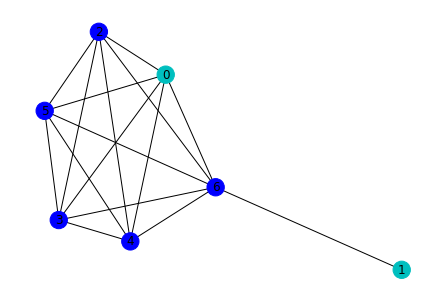

In [13]:
vs.draw_connectivity_graph()
from pydrake.all import Rgba
samples_t = np.array([Ratfk.ComputeTValue( vs.samples_outside_regions[q_s][0], np.zeros(3)) for q_s in vs.samples_outside_regions.keys()])
seeds_t = np.array([Ratfk.ComputeTValue( p, np.zeros(3)) for p in vs.seed_points])

vis_seed = [[seeds_t[vs.regions.index(k)] for k in vis2[1]] for vis2 in vs.samples_outside_regions.values()]
visualizer.plot_points(seeds_t, size = 0.06, color = Rgba(1., 0.0, 1.0, 0.6), start_idx = 0, prefix = 'seed')
visualizer.plot_points(samples_t, size = 0.02, color = Rgba(0., 0.1, 0.0, 0.3), start_idx = len(seeds_t), prefix = 'sample')
visualizer.plot_regions(vs.regions,
                        ellipses= None,#[r.MaximumVolumeInscribedEllipsoid() for r in vs.regions],
                        region_suffix='_guard')

# Connectivity Phase


In [14]:
vs.connectivity_phase()

True

In [15]:
#vs.fill_remaining_space_phase()

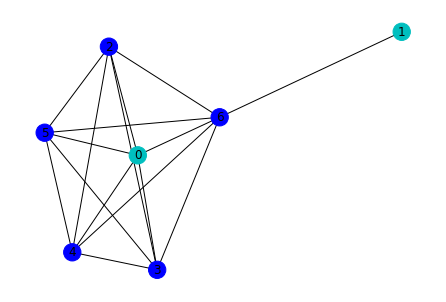

In [16]:
visualizer.plot_regions(vs.regions[len(vs.guard_regions):],
                        ellipses=None, #[r.MaximumVolumeInscribedEllipsoid() for r in vs.regions[len(vs.guard_regions):]],
                        region_suffix='_connectivity', colors=[(255,0,255) for i in range(len(vs.guard_regions))])
vs.draw_connectivity_graph()

In [17]:
dspp = DijkstraSPPsolver(vs.regions,
                         partial(Ratfk.ComputeTValue, q_star_val = np.zeros(3)))

In [18]:
# from scipy.sparse.csgraph import dijkstra, csgraph_from_dense
# from scipy.sparse import coo_matrix
# from pydrake.all import (MathematicalProgram, Variable, HPolyhedron, le, SnoptSolver, Solve) 

# class node:
#     def __init__(self, loc, regs = None):
#         self.loc = loc
#         if regs is None:
#             self.regions = []
#         else:
#             self.regions = regs

# def dijkstra_in_configspace(adj_mat):
#     # convention for start and target
#     src = adj_mat.shape[0] -2
#     target = adj_mat.shape[0] -1
#     dist, pred = dijkstra(adj_mat, directed=False, indices=src, return_predecessors=True)
#     #print(f'{len(np.argwhere(pred == -9999))} disconnected nodes'), #np.argwhere(pred == -9999))
#     idxs = (pred == -9999)
#     pred[idxs] = -100000000
#     dist[idxs] = -1000000
#     sp_list = []
#     sp_length = dist[target]
#     #print(sp_length)
#     if sp_length<0:
#         return [], sp_length
#     current_idx = target
#     sp_list.append(current_idx)
#     while not current_idx == adj_mat.shape[0] - 2:
#         current_idx = pred[current_idx]
#         sp_list.append(current_idx)
#         if current_idx==src: break
#     return [idx for idx in sp_list[::-1]], sp_length

# def build_base_adjacency_matrix(regions_list):    
#     nodes_intersections = []
#     for idx, r in enumerate(regions_list[:-1]):
#         for r2 in regions_list[idx+1:]:
#             if r.IntersectsWith(r2):
#                 try:
#                     loc = r.Intersection(r2).MaximumVolumeInscribedEllipsoid().center()
#                     nodes_intersections.append(node(loc, [r, r2]))
#                 except:
#                     print('failed ', idx)

#     node_locations = [node.loc for node in nodes_intersections]
#     adjacency_list = []
#     adjacency_dist = []
#     for n in nodes_intersections:
#         edges = []
#         edge_dist = []
#         for n2 in nodes_intersections:
#             if nodes_intersections.index(n) != nodes_intersections.index(n2):
#                 n_regs = set([str(r) for r in n.regions])
#                 n2_regs = set([str(r) for r in n2.regions])
#                 if len(list(n_regs&n2_regs)):
#                     edges.append(nodes_intersections.index(n2))
#                     edge_dist.append(np.linalg.norm(n.loc-n2.loc))
#         adjacency_list.append(edges)
#         adjacency_dist.append(edge_dist)
    
#     N = len(node_locations)
#     data = []
#     rows = []
#     cols = []

#     ad_mat = coo_matrix((N, N), np.float32)

#     for idx in range(N):
#         nei_idx = 0
#         for nei in adjacency_list[idx]:
#             if not nei == idx:
#                 data.append(adjacency_dist[idx][nei_idx])
#                 rows.append(idx)
#                 cols.append(nei)
#             nei_idx += 1

#     ad_mat = coo_matrix((data, (rows, cols)), shape=(N, N))
#     return ad_mat, nodes_intersections

# def extend_adjacency_mat(start_q, target_q, base_ad_mat, node_intersections, region_list, point_conversion):
#     #first check point memberships
#     start_idx = -1
#     target_idx = -1
#     start_conv = point_conversion(start_q)
#     target_conv = point_conversion(target_q)
#     for idx, r in enumerate(region_list):
#         if start_idx<0 and r.PointInSet(start_conv):
#             start_idx = idx
#         if target_idx<0 and r.PointInSet(target_conv):
#             target_idx = idx
#         if start_idx >=0 and target_idx >=0:
#             break
#     if start_idx <0 or target_idx <0:
#         print('points not in set, idxs', start_idx,', ', target_idx)
#         return None
#     N = len(node_intersections) + 2
#     data = list(base_ad_mat.data)
#     rows = list(base_ad_mat.row)
#     cols = list(base_ad_mat.col)
#     #get idstances of all nodes  
#     start_region = region_list[start_idx]
#     target_region = region_list[target_idx]
#     start_adj_idx = N-2
#     target_adj_idx = N-1
#     for node_idx, node in enumerate(node_intersections):
#         if start_region in node.regions:
#             dist = np.linalg.norm(start_conv-node.loc)
#             data.append(dist)
#             rows.append(start_adj_idx)
#             cols.append(node_idx)
#             data.append(dist)
#             rows.append(node_idx)
#             cols.append(start_adj_idx)
#         if target_region in node.regions:
#             dist = np.linalg.norm(target_conv-node.loc)
#             data.append(dist)
#             rows.append(target_adj_idx)
#             cols.append(node_idx)
#             data.append(dist)
#             rows.append(node_idx)
#             cols.append(target_adj_idx)
    
#     ad_mat_extend = coo_matrix((data, (rows, cols)), shape=(N, N))
#     return ad_mat_extend

# def refine_path_QP(wps, start_t, target_t, intersection_nodes):
#     intermediate_nodes = [intersection_nodes[idx] for idx in wps[1:-1]]
#     dim = len(intersection_nodes[0].loc)
#     prog = MathematicalProgram()
#     intermediates = []
#     for idx, wpnode in enumerate(intermediate_nodes):
#         x = prog.NewContinuousVariables(dim, 'x'+str(idx))
#         intermediates.append(x)
#         prog.SetInitialGuess(x, wpnode.loc)
#         for r in wpnode.regions:
#             prog.AddConstraint(le(r.A()@x, r.b())) 

#     cost = 0
#     prev = start_t
#     for pt in intermediates + [target_t]:
#         a = (prev-pt) #* np.array([4.0,3.5,3,2.5,2,2.5,1]) 
#         cost += a.T@a
#         prev = pt
#     prog.AddCost(cost)

#     res = Solve(prog)
#     if res.is_success():
#         path = [start_t]
#         for i in intermediates:
#             path.append(res.GetSolution(i))
#         path.append(target_t)
#         wps_start = [intersection_nodes[idx].loc for idx in wps[1:-1]]
#         dist_start = 0
#         prev = start_t
#         for wp in wps_start + [target_t]:
#             #dist_start += np.linalg.norm()#* np.array([4.0,3.5,3,2.5,2,2.5,1])
#             a = prev-wp
#             dist_start += a.T@a
#             prev = wp
#         print("[DijkstraSPP] optimized distance/start distance = {opt:.2f} / {start:.2f} = {res:.2f}".format(opt = res.get_optimal_cost(), start = dist_start, res = res.get_optimal_cost()/dist_start))
#     return path, res.get_optimal_cost()

# def dijkstra_spp(start_q,
#                  target_q,
#                  intersection_nodes, 
#                  base_ad_mat, 
#                  region_list, 
#                  point_conversion,
#                  optimize = True):
#     #N = len(intersection_nodes)
#     ad_mat = extend_adjacency_mat(start_q, target_q, base_ad_mat, intersection_nodes, region_list, point_conversion)
#     if ad_mat is not None:
#         wps, dist = dijkstra_in_configspace(adj_mat=ad_mat)
#         if dist<0:
#             print('[DijkstraSPP] Points not reachable')
#             return [], -1
#         if optimize:
#             location_wps_optimized_t, dist_optimized = refine_path_QP(wps, 
#                                                                       point_conversion(start_q), 
#                                                                       point_conversion(target_q), 
#                                                                     intersection_nodes)

#             return location_wps_optimized_t, dist_optimized
#         else:
#             intermediate_nodes = [intersection_nodes[idx].loc for idx in wps[1:-1]]
#             waypoints = [point_conversion(start_q)] + intermediate_nodes + [point_conversion(target_q)]
#             return waypoints, dist
#     else:
#         print('[DijkstraSPP] Points not in regions')
#         return [], -1

In [29]:
from pydrake.all import Rgba, Sphere, RotationMatrix
def densify_waypoints(waypoints_t):
    densify = 150
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_t[:-1])):
        a = waypoints_t[idx]
        b = waypoints_t[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            ta = a*tval + b*(1-tval)
            qa = Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            visualizer.plant.SetPositions(visualizer.plant_context,qa)
            #visualizer.set_joint_angles(qa)
            tf_tot= plant.EvalBodyPoseInWorld(visualizer.plant_context, visualizer.plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.45
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(0.1)#)np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_t[idx]*tval + waypoints_t[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints, opt = True):
    color = Rgba(1,0,0,1.0)
    color2 = Rgba(0,0,1,1.0)
    color3 = Rgba(0,1,1,1.0)
    start_idx = 0
    for i, ta in enumerate(dense_waypoints[::2]):
        qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        visualizer.plant.SetPositions(visualizer.plant_context,qa)
        tf_tot= visualizer.plant.EvalBodyPoseInWorld(visualizer.plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(12)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        visualizer.meshcat1.SetObject(f"/iris/points/traj/{i+start_idx}",
                               Sphere(0.005),
                               color)

        visualizer.meshcat1.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
        
        tf_tot= visualizer.plant.EvalBodyPoseInWorld(visualizer.plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(20)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        visualizer.meshcat1.SetObject(f"/iris/points/traj2/{i+start_idx}",
                               Sphere(0.005),
                               color2)

        visualizer.meshcat1.SetTransform(f"/iris/points/traj2/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
        
        visualizer.meshcat2.SetObject(f"/iris/points/traj2/{i+start_idx}",
                               Sphere(0.02),
                               color3)

        visualizer.meshcat2.SetTransform(f"/iris/points/traj2/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  ta))
        

In [21]:
# base_ad_mat, node_intersections = build_base_adjacency_matrix(vs.regions)
# point_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(3))

In [33]:
import time

start = poi[np.random.choice(len(poi),1)[0]]
for _ in range(20):
    nxt = vs.sample_in_regions() #
#     while True:
#         nxt = poi[np.random.choice(len(poi),1)[0]]
#         if nxt[0] != start[0]:
#             break
    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    print(dist)
    if dist >0:
        dense_waypoints = densify_waypoints(wp)
        plot_endeff_traj(dense_waypoints)
        for ta in dense_waypoints:
            qa = Ratfk.ComputeQValue(ta, np.zeros(3))
            visualizer.showres(qa)
            if visualizer.col_func_handle(qa):
                print(col)
                break
            time.sleep(0.002)
        start = nxt
        time.sleep(0.1)
        visualizer.meshcat1.Delete("/iris/points/traj/")
        visualizer.meshcat1.Delete("/iris/points/traj2/")
        visualizer.meshcat2.Delete("/iris/points/traj2/")
    else:
        nxt = vs.sample_in_regions()

[DijkstraSPP] optimized distance/start distance = 0.30 / 0.70 = 0.43
0.3043517377986227
[DijkstraSPP] optimized distance/start distance = 0.16 / 0.43 = 0.37
0.15848321683508937
[DijkstraSPP] optimized distance/start distance = 0.37 / 0.75 = 0.50
0.3735048989421278
[DijkstraSPP] optimized distance/start distance = 0.42 / 1.75 = 0.24
0.4150221849922042
[DijkstraSPP] optimized distance/start distance = 0.78 / 1.58 = 0.50
0.7821257869712728
[DijkstraSPP] optimized distance/start distance = 0.02 / 0.10 = 0.21
0.019790475546367536
[DijkstraSPP] optimized distance/start distance = 0.54 / 1.84 = 0.29
0.5375674473637562
[DijkstraSPP] optimized distance/start distance = 0.25 / 0.81 = 0.30
0.2465086922191222
[DijkstraSPP] optimized distance/start distance = 0.16 / 0.39 = 0.40
0.1573254752396369
[DijkstraSPP] optimized distance/start distance = 0.36 / 0.80 = 0.45
0.3576891339450968
[DijkstraSPP] optimized distance/start distance = 0.85 / 1.20 = 0.71
0.853759162266752
[DijkstraSPP] optimized distan

# Experiments with default iris

In [23]:
regions = vs.regions[:-1]
obstacles = []
q_seed = np.array([-0.51034035, -0.25427137, -0.65290974])
for r in regions:
    offset = 0.25*np.min(1/np.linalg.eig(r.MaximumVolumeInscribedEllipsoid().A())[0])
    rnew = HPolyhedron(r.A(), r.b()-offset)
    obstacles.append(rnew)
try:
    t_seed = Ratfk.ComputeTValue(q_seed, np.zeros((3,)))
    domain_new = Iris(obstacles, t_seed, domain, iris_options)
    print("[SNOPTIRIS] Domain succefully restricted")
except:
    print("[SNOPTIRIS] Domain restriction failed")
    domain = default_domain

[SNOPTIRIS] Domain succefully restricted


In [24]:
domain_new

In [28]:
visualizer.plot_regions([domain_new],
                        ellipses=None,
                        region_suffix='_IRISstand', colors=[(255,255,0)])

visualizer.plot_regions([domain],
                        ellipses=None,
                        region_suffix='_IRISstand2', colors=[(255,0,255)])
visualizer.plot_regions(obstacles,
                        ellipses=None,
                        region_suffix='_obstacles', colors=[(0,255,0)]*len(obstacles))

In [35]:
print(poi[0])
a = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(3))

[ 1.6 -0.4 -1.3]


In [36]:
print(a(poi[0]))
print(poi[0])

[ 1.02963856 -0.20271004 -0.7602044 ]
[ 1.6 -0.4 -1.3]


In [37]:
print(Ratfk.ComputeTValue(poi[0], np.zeros(3)))
print(poi[0])

[ 1.02963856 -0.20271004 -0.7602044 ]
[ 1.6 -0.4 -1.3]
